In [1]:
import requests
import csv
import pytz
import time
from datetime import datetime, timedelta

In [76]:
# start_ts = 1204329600  # 2008-03-01
start = datetime(2014, 4, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 =  '192.33.4.12'
prefix6 = '2001:500:2::C'

In [77]:
def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_state = []
    if data:
        for item in data:
            route_info = {
                'peer': item['path'][0],
                'root': item['path'][-1],
                'as_path': list(deduplicate(item['path']))
            }
            bgp_state.append(route_info)

    peer = [item['peer'] for item in bgp_state]

    return bgp_state, peer

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

In [75]:
utc = pytz.utc
with open('c-root-mutual-as-path-stats.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter=',')
    # csv header first
    writer.writerow(['time', 'identical', 'diff', 'v4_longer', 'v4_shorter'])
    cur_date = start
    while cur_date <= stop:
        print(cur_date)
        
        utc_dt = utc.localize(cur_date)
        timestamp = int(time.mktime(utc_dt.timetuple()))
        
        bgp_state4, peer4 = get_peers(prefix4, timestamp)
        bgp_state6, peer6 = get_peers(prefix6, timestamp)
        
        mutual_peers = list(set(peer4) & set(peer6))
        
        mutual_peers_stat = get_peers_stat(mutual_peers, bgp_state4, bgp_state6)
        
        time_str = cur_date.strftime('%Y-%m-%d')
        result_all = len([i['peer'] for i in mutual_peers_stat])
        result_identical = len([i['peer'] for i in mutual_peers_stat if i['similar'] == 1])
        result_diff = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) == len(i['path6']) and i['similar'] == 0])
        result_v4_longer = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) > len(i['path6'])])
        result_v4_shorter = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) < len(i['path6'])])
        
        writer.writerow((time_str, result_identical, result_diff, result_v4_longer, result_v4_shorter))
        
        year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
        month = 1 if cur_date.month == 12 else cur_date.month + 1
        cur_date = datetime(year, month, 1, 1, 0, 0)

2014-04-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.33.4.12&timestamp=1396310400
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2::C&timestamp=1396310400
2014-05-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.33.4.12&timestamp=1398902400
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2::C&timestamp=1398902400
2014-06-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.33.4.12&timestamp=1401580800
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2::C&timestamp=1401580800
2014-07-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.33.4.12&timestamp=1404172800
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2::C&timestamp=1404172800
2014-08-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.33.4.12&timestamp=1406851200
g

### Draw some graph

In [2]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [36]:
df = pd.read_csv('c-root-mutual-as-path-stats.csv', index_col=0)
df

,identical,diff,v4_longer,v4_shorter
time,,,,
2014-04-01,41,9,2,3
2014-05-01,40,10,2,4
2014-06-01,39,9,2,4
2014-07-01,38,9,2,4
2014-08-01,39,8,2,5
2014-09-01,35,9,2,3
2014-10-01,35,5,2,5
2014-11-01,39,10,2,6
2014-12-01,40,9,2,5


This is supposed to transform wide-mode data into long-mode data, as required in ggplot. But somehow the plot is still incorrect

In [78]:
df2 = pd.melt(df, id_vars=['time'])
df2

KeyError: 'time'

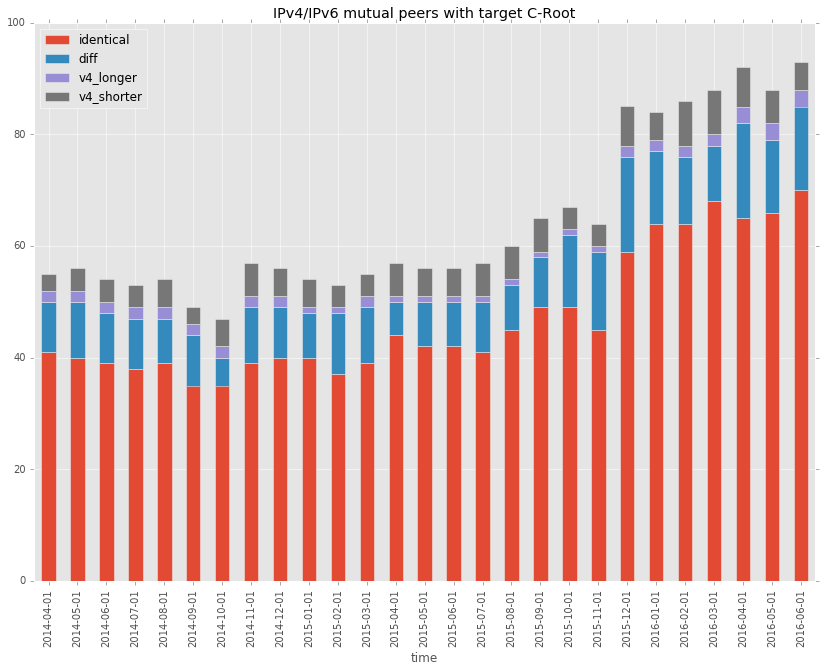

In [37]:
df.plot.bar(stacked=True, figsize=(14,10), title='IPv4/IPv6 mutual peers with target C-Root')

from the graph above, it can be seen that the number of mutual peers grow over the time. Peers can be categorized into two: peers with identical AS path for IPv4 and IPv6, and peer with different AS path. We are in particular interested in the second category, since it shows that there is IPv4/IPv6 routing discrepancy for those peers.

Back to the graph again. At a glance, it seems that the network is converging; more peers with identical AS path. However, the ratio of those 4 types of peers are relatively constant. 

Why? That is the next question

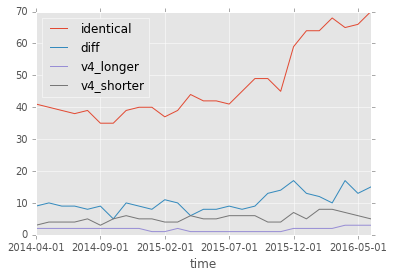

In [38]:
df.plot()

### Plot without peers with identical AS path

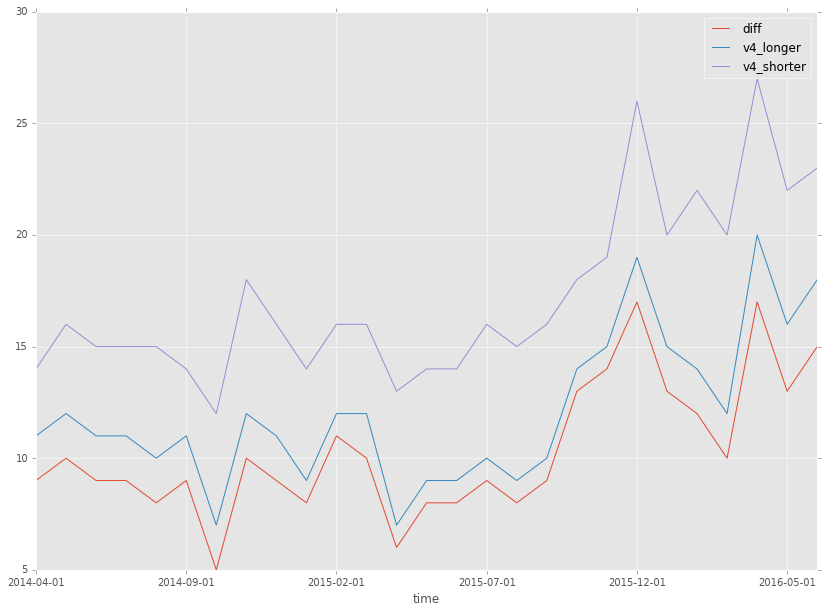

In [39]:
df[['diff', 'v4_longer', 'v4_shorter']].plot(stacked=True, figsize=(14,10))

### Plot in percentage

In [67]:
import numpy as np

df3 = pd.read_csv('c-root-mutual-as-path-stats.csv', index_col=0, dtype={'identical': np.float64, 'diff': np.float64, 'v4_longer': np.float64, 'v4_shorter': np.float64})

In [68]:
for index, row in df3.iterrows():
    total = sum(row)
    df3.set_value(index, 'identical', (row['identical'] / total) * 100)
    df3.set_value(index, 'diff', (row['diff'] / total) * 100)
    df3.set_value(index, 'v4_longer', (row['v4_longer'] / total) * 100)
    df3.set_value(index, 'v4_shorter', (row['v4_shorter'] / total) * 100)

In [69]:
df3

,identical,diff,v4_longer,v4_shorter
time,,,,
2014-04-01,74.545455,16.363636,3.636364,5.454545
2014-05-01,71.428571,17.857143,3.571429,7.142857
2014-06-01,72.222222,16.666667,3.703704,7.407407
2014-07-01,71.698113,16.981132,3.773585,7.547170
2014-08-01,72.222222,14.814815,3.703704,9.259259
2014-09-01,71.428571,18.367347,4.081633,6.122449
2014-10-01,74.468085,10.638298,4.255319,10.638298
2014-11-01,68.421053,17.543860,3.508772,10.526316
2014-12-01,71.428571,16.071429,3.571429,8.928571


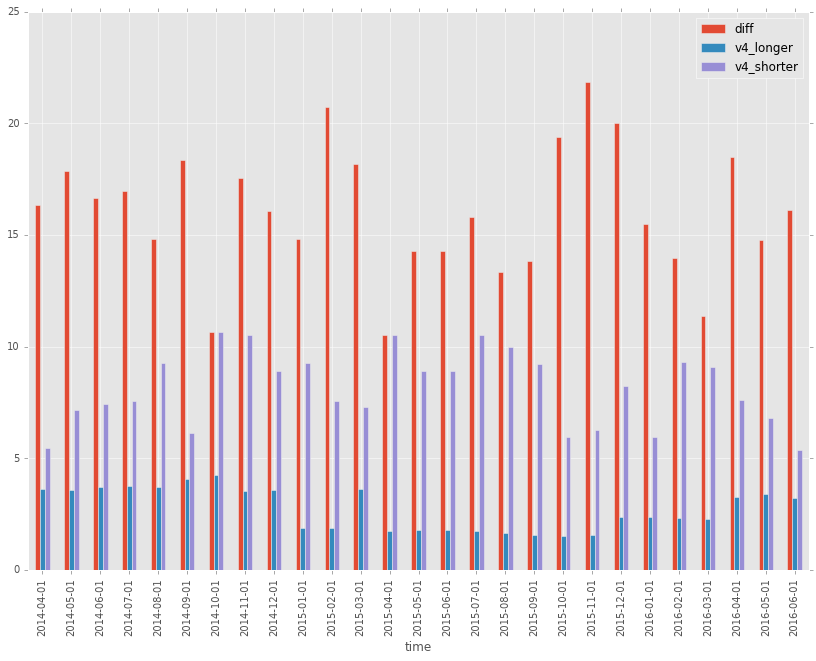

In [72]:
df3[['diff', 'v4_longer', 'v4_shorter']].plot.bar(figsize=(14,10))

well, actually, they are not that constant. But 'v4_shorter' is more consistent.
Let's move on the more important analysis

# RQ: How different is IPv4 and IPv6 catchment areas?

## RQ.1 Peer degree distribution for each IPv4/IPv6?

In [3]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests
import pytz
import time
from datetime import datetime

matplotlib.style.use('ggplot')

timestamp = 1464739200 # 2013-06-01
# url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
prefix4 =  '192.33.4.12'
prefix6 = '2001:500:2::C'

### find out

First, find out the mutual peers

In [4]:
def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
            bgp_data[item['path'][0]] = list(deduplicate(item['path']))
            peers.append(item['path'][0])
    return bgp_data, peers

data4, peer4 = get_peers(prefix4, timestamp)
data6, peer6 = get_peers(prefix6, timestamp)

mutual_peers = list(set(peer4) & set(peer6))

get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.33.4.12&timestamp=1464739200
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2::C&timestamp=1464739200


then, find mutual peers with different path

In [5]:
mutual_peers_diff = {}

for peer in mutual_peers:
    if data4[peer] != data6[peer]:
        mutual_peers_diff[peer] = {'path4': data4[peer], 'path6': data6[peer]}

In [6]:
from pandas import DataFrame

processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')
processed_data

,path6,path4
513,"[513, 3320, 174, 2149]","[513, 6730, 174, 2149]"
680,"[680, 3356, 174, 2149]","[680, 174, 2149]"
1853,"[1853, 21320, 174, 2149]","[1853, 1764, 174, 2149]"
6720,"[6720, 1853, 21320, 174, 2149]","[6720, 1853, 1764, 174, 2149]"
9002,"[9002, 2914, 174, 2149]","[9002, 3356, 174, 2149]"
9189,"[9189, 8422, 174, 2149]","[9189, 8422, 3356, 174, 2149]"
13237,"[13237, 1299, 174, 2149]","[13237, 3257, 174, 2149]"
14061,"[14061, 2914, 174, 2149]","[14061, 1299, 174, 2149]"
14840,"[14840, 18881, 12956, 174, 2149]","[14840, 26615, 6762, 174, 2149]"
28329,"[28329, 3549, 3356, 174, 2149]","[28329, 6762, 174, 2149]"


In [7]:
for index, row in processed_data.iterrows():
    processed_data.set_value(index, 'len4', len(row['path4']))
    processed_data.set_value(index, 'len6', len(row['path6']))
processed_data

,path6,path4,len4,len6
513,"[513, 3320, 174, 2149]","[513, 6730, 174, 2149]",4.0,4.0
680,"[680, 3356, 174, 2149]","[680, 174, 2149]",3.0,4.0
1853,"[1853, 21320, 174, 2149]","[1853, 1764, 174, 2149]",4.0,4.0
6720,"[6720, 1853, 21320, 174, 2149]","[6720, 1853, 1764, 174, 2149]",5.0,5.0
9002,"[9002, 2914, 174, 2149]","[9002, 3356, 174, 2149]",4.0,4.0
9189,"[9189, 8422, 174, 2149]","[9189, 8422, 3356, 174, 2149]",5.0,4.0
13237,"[13237, 1299, 174, 2149]","[13237, 3257, 174, 2149]",4.0,4.0
14061,"[14061, 2914, 174, 2149]","[14061, 1299, 174, 2149]",4.0,4.0
14840,"[14840, 18881, 12956, 174, 2149]","[14840, 26615, 6762, 174, 2149]",5.0,5.0
28329,"[28329, 3549, 3356, 174, 2149]","[28329, 6762, 174, 2149]",4.0,5.0


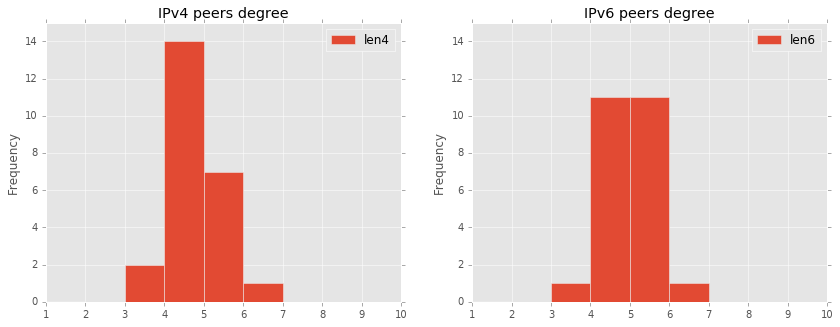

In [8]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2)

processed_data[['len4']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[0], ylim=(0, 15), title='IPv4 peers degree')
processed_data[['len6']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[1], ylim=(0, 15), title='IPv6 peers degree')

## RQ.2 AS path length average?

In [9]:
avg4 = processed_data['len4'].mean()
avg6 = processed_data['len6'].mean()

print('IPv4 average path length: {}'.format(avg4))
print('IPv6 average path length: {}'.format(avg6))

IPv4 average path length: 4.291666666666667
IPv6 average path length: 4.5


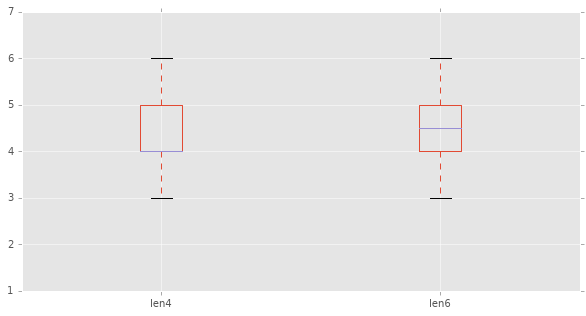

In [10]:
processed_data[['len4', 'len6']].plot.box(figsize=(10,5), ylim=(1,7))

## RQ.3 ASes most frequently seen?

### for IPv4

In [11]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

res = []

for item in processed_data['path4']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv4 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 


Most frequently seen ASes in IPv4 AS paths:
174	24
3356	6
6762	3
2914	2
1764	2
8758	1
6730	1
29691	1
1251	1
12956	1
39326	1
24611	1
8422	1
51945	1
13101	1
10429	1
20080	1
1299	1
6453	1
26615	1
3257	1
12586	1
1853	1


Most frequently seen per degree (degree is as seen from Root ASN)

In [12]:
max = processed_data['len4'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path4']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	174	24
(*) Hop 2:
	3356	6
	6762	3
	2914	2
	1764	2
	680	1
	6730	1
	51945	1
	13101	1
	1299	1
	6453	1
	8758	1
	49463	1
	3257	1
	29691	1
	12956	1
(*) Hop 3:
	1853	2
	31424	1
	513	1
	57118	1
	24611	1
	29636	1
	8422	1
	29608	1
	28329	1
	9002	1
	196621	1
	14061	1
	10429	1
	20080	1
	31122	1
	13237	1
	29686	1
	26615	1
	56730	1
	12586	1
	39326	1
(*) Hop 4:
	6720	1
	1251	1
	9189	1
	14840	1
	31019	1
	51405	1
	53070	1
	57821	1
(*) Hop 5:
	52888	1


### for IPv6

In [13]:
res = []

for item in processed_data['path6']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv6 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 

Most frequently seen ASes in IPv6 AS paths:
174	24
2914	4
3356	3
1299	3
21320	2
15576	2
18881	1
6661	1
43531	1
196621	1
12989	1
1251	1
8218	1
3549	1
39326	1
16735	1
24611	1
8422	1
13030	1
12956	1
12586	1
1853	1
6453	1
51945	1
3320	1
3257	1
1916	1
6461	1


Most frequently seen per degree

In [14]:
max = processed_data['len6'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path6']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	174	24
(*) Hop 2:
	2914	4
	3356	3
	1299	3
	21320	2
	15576	2
	29636	1
	6661	1
	8422	1
	1916	1
	6453	1
	3320	1
	3257	1
	12956	1
	6461	1
	16735	1
(*) Hop 3:
	196621	2
	1853	2
	513	1
	24611	1
	9189	1
	13030	1
	18881	1
	680	1
	9002	1
	43531	1
	14061	1
	29608	1
	31122	1
	1251	1
	12586	1
	13237	1
	29686	1
	8218	1
	12989	1
	3549	1
	39326	1
(*) Hop 4:
	6720	1
	31424	1
	51945	1
	31019	1
	51405	1
	28329	1
	52888	1
	53070	1
	49463	1
	14840	1
	57821	1
	57118	1
(*) Hop 5:
	56730	1


## RQ.4 For shorter IPv6 path (longer IPv4 path), which ASes frequently appear as transit?

In [15]:
temp= []
for item in processed_data.iterrows():
#     print(item[1]['path4'])
    if item[1]['len4'] > item[1]['len6']:
#         print('v4: {}\tv6: {}'.format(item[1]['path4'], item[1]['path6']))
        for asn in item[1]['path6'][1:-1]:
            temp.append(asn)

results = most_common(temp)
for result in results:
    print('{}\t{}'.format(result[0], result[1]))
        

174	3
1251	1
1916	1
8422	1


## RQ.5 For peers with same path length but different path, how different is it?

calculate the percentage of different AS hop, and find out which ASes are frequently appear in the IPv6 path

In [16]:
temp = []
for item in processed_data.iterrows():
    if len(item[1]['path4']) == len(item[1]['path6']):
#         print('v4:{}\t\t\tv6:{}'.format(item[1]['path4'][1:-1], item[1]['path6'][1:-1]))
        diff_counter = 0
        path_length = len(item[1]['path4'])
        for i in range(0, path_length):
            if item[1]['path4'][i] != item[1]['path6'][i]:
                temp.append(item[1]['path6'][i])
                diff_counter += 1
        diff_pct = (diff_counter / path_length) * 100
        print('Peer {}: \tlength:{} \tdifference: {}%'.format(item[0], path_length, diff_pct))

print('\nMost common ASes appear in IPv6 path that differs with IPv4 path')
results = most_common(temp)
for result in results:
    print('\t{}\t{}'.format(result[0], result[1]))

Peer 513: 	length:4 	difference: 25.0%
Peer 1853: 	length:4 	difference: 25.0%
Peer 6720: 	length:5 	difference: 20.0%
Peer 9002: 	length:4 	difference: 25.0%
Peer 13237: 	length:4 	difference: 25.0%
Peer 14061: 	length:4 	difference: 25.0%
Peer 14840: 	length:5 	difference: 40.0%
Peer 29608: 	length:4 	difference: 25.0%
Peer 29686: 	length:4 	difference: 25.0%
Peer 31019: 	length:5 	difference: 40.0%
Peer 31122: 	length:4 	difference: 25.0%
Peer 51405: 	length:5 	difference: 20.0%
Peer 53070: 	length:5 	difference: 40.0%
Peer 57821: 	length:5 	difference: 20.0%
Peer 196621: 	length:4 	difference: 25.0%

Most common ASes appear in IPv6 path that differs with IPv4 path
	2914	3
	21320	2
	1299	2
	18881	1
	6661	1
	3356	1
	43531	1
	15576	1
	6453	1
	3320	1
	3257	1
	12956	1
	12989	1
	16735	1


## RQ.6 Can we correlate the path difference to their physical location? (based on the location of RIS collector)

# RQ: How do IPv4 and IPv6 catchment areas evolve over time?

Note that here we only use mutual peers that have different IPv4/IPv6 path

`common_mutual_peers` is the container of dual-stack mutual peers that exist since the start of dual-stack operation of the Root Server

`common_mutual_peers` = [1280, 25091, 25220, 8596, 7575, 56730, 286, 57381, 553, 9002, 13237, 8758, 3257, 12859, 1853, 6720, 25152, 2497, 29636, 20932, 15435, 1103, 19151, 29140, 12637, 2914, 9189, 13030, 6762, 4589, 34288, 28917, 29686, 22652]

~~Now, we should get AS path data since the start, for each common_mutual_peers~~ Path data is already in Neo4j.

_**Visualization idea**_: create tree timelapse using those peers, to visualize whether there is change in the path throughout the time or not

## RQ.1 IPv4/IPv6 peer degree distribution over time?

In [2]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests
from datetime import datetime
import pytz
import time
import csv
from pandas import DataFrame

# matplotlib.style.use('ggplot')

# timestamp = 1464739200 # 2013-06-01
start = datetime(2014, 4, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2008, 6, 1, 1, 0, 0)
utc = pytz.utc

prefix4 =  '192.33.4.12'
prefix6 = '2001:500:2::C'

### *Helper methods*

In [3]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    """
    to remove AS prepending
    """
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
#     print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
#             bgp_data[item['path'][0]] = list(deduplicate(item['path']))
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers


def get_mutual_peer_with_diff_paths(timestamp):
    """
    get mutual peer with different IPv4/IPv6 paths
    """
    data4, peer4 = get_peers(prefix4, timestamp)
    data6, peer6 = get_peers(prefix6, timestamp)

    mutual_peers = list(set(peer4) & set(peer6))

    mutual_peers_diff = {}

    for peer in mutual_peers:
    #     print(peer)
        if data4[peer]['path'] != data6[peer]['path']:
    #         print(data4[peer]['path'])
            mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}
    
    return mutual_peers_diff

## Get data, write to .csv file

run only once!

In [6]:
result = {}
cur_date = start
print('start.....')
while cur_date <= stop:
    # do something here
    utc_dt = utc.localize(cur_date)
    timestamp = int(time.mktime(utc_dt.timetuple()))
    
    mutual_peers_diff = get_mutual_peer_with_diff_paths(timestamp)

    processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')

    for index, row in processed_data.iterrows():
        processed_data.set_value(index, 'len4', len(row['path4']))
        processed_data.set_value(index, 'len6', len(row['path6']))
    
    path_file = 'datasets/c/{}-path.csv'.format(timestamp)
    processed_data.to_csv(path_file, sep='\t')
    
    # increment cur_date
    year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
    month = 1 if cur_date.month == 12 else cur_date.month + 1
    cur_date = datetime(year, month, 1, 1, 0, 0)

print('stop...')

start.....
stop...


### Data Analysis

In [4]:
import os

In [5]:
result4 = {}
result6 = {}
for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4'].value_counts()
        result4[timestamp] = res4
        res6 = opened_file['len6'].value_counts()
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()
print('finish.')

finish.


In [28]:
result4

{1396310400: 4.0    7
 5.0    6
 3.0    1
 Name: len4, dtype: int64, 1398902400: 4.0    9
 5.0    6
 3.0    1
 Name: len4, dtype: int64, 1401580800: 4.0    8
 5.0    5
 3.0    2
 Name: len4, dtype: int64, 1404172800: 4.0    8
 5.0    5
 3.0    2
 Name: len4, dtype: int64, 1406851200: 4.0    7
 5.0    5
 3.0    3
 Name: len4, dtype: int64, 1409529600: 4.0    7
 5.0    4
 3.0    3
 Name: len4, dtype: int64, 1412121600: 5.0    5
 3.0    4
 4.0    3
 Name: len4, dtype: int64, 1414800000: 4.0    8
 5.0    7
 3.0    3
 Name: len4, dtype: int64, 1417392000: 4.0    10
 5.0     5
 3.0     2
 Name: len4, dtype: int64, 1420070400: 4.0    7
 5.0    5
 3.0    3
 Name: len4, dtype: int64, 1422748800: 4.0    10
 5.0     5
 3.0     2
 Name: len4, dtype: int64, 1425168000: 4.0    10
 5.0     5
 3.0     2
 Name: len4, dtype: int64, 1427846400: 4.0    7
 5.0    4
 3.0    3
 Name: len4, dtype: int64, 1430438400: 4.0    8
 5.0    6
 3.0    2
 Name: len4, dtype: int64, 1433116800: 4.0    9
 5.0    5
 3.0   

### Plot

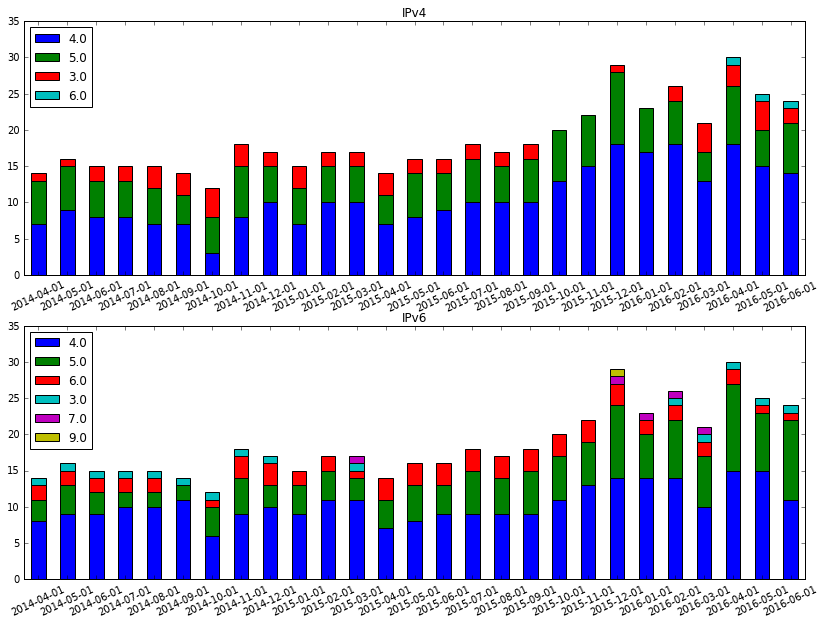

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1)

# ipv4
plot_result4 = DataFrame.from_dict(result4, orient='index')
plot_result6 = DataFrame.from_dict(result6, orient='index')

plot4 = plot_result4.plot.bar(stacked=True, ax=axes[0], ylim=(0, 35), figsize=(14,10), title='IPv4')
plot6 = plot_result6.plot.bar(stacked=True, ax=axes[1], ylim=(0, 35), figsize=(14,10), title='IPv6')

n = 1

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.2 AS path average length?

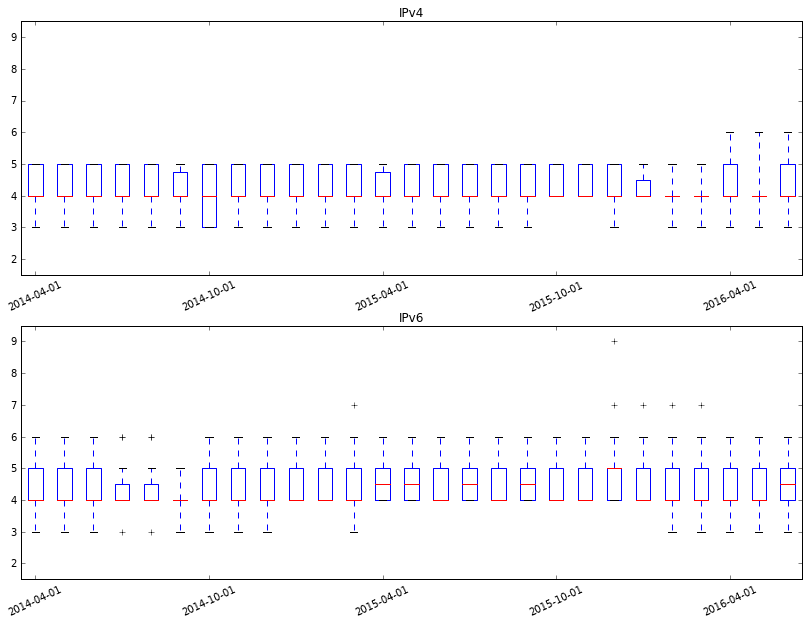

In [7]:
result4 = {}
result6 = {}
for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4']
        res6 = opened_file['len6']
        result4[timestamp] = res4
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()

plot_result4 = DataFrame.from_dict(result4)
plot_result6 = DataFrame.from_dict(result6)


################
# Plot
################
fig, axes = plt.subplots(nrows=2, ncols=1)

plot4 = plot_result4.plot.box(figsize=(14,10), ax=axes[0], ylim=(1.5,9.5), title='IPv4')
plot6 = plot_result6.plot.box(figsize=(14,10), ax=axes[1], ylim=(1.5,9.5), title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

### RQ.3 Most frequently seen ASes on the path?

### IPv4

In [8]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path4']:
            # transform string of AS path into python's list
            path4 = item[1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            # exclude origin AS and probe AS
            for i in path4[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv4 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv4 AS paths (2014-04-01):
174	14
3356	4
1764	2
3330	1
8422	1
7473	1
1916	1
4844	1
13101	1
3320	1

[*] Most frequently seen ASes in IPv4 AS paths (2014-05-01):
174	16
3356	4
1764	2
3257	2
3330	1
8422	1
7473	1
1916	1
6762	1
4844	1

[*] Most frequently seen ASes in IPv4 AS paths (2014-06-01):
174	15
3356	5
1764	2
3330	1
8422	1
1916	1
13101	1
1299	1
42708	1
3257	1

[*] Most frequently seen ASes in IPv4 AS paths (2014-07-01):
174	15
3356	4
1764	2
3330	1
8422	1
1916	1
13101	1
3320	1
1299	1
42708	1

[*] Most frequently seen ASes in IPv4 AS paths (2014-08-01):
174	15
3356	4
1764	2
3330	1
8422	1
1916	1
13101	1
6461	1
3320	1
1299	1

[*] Most frequently seen ASes in IPv4 AS paths (2014-09-01):
174	14
1764	2
3356	2
2914	1
8422	1
25512	1
3330	1
13101	1
1299	1
42708	1

[*] Most frequently seen ASes in IPv4 AS paths (2014-10-01):
174	12
1764	2
3330	1
8422	1
51945	1
4844	1
13101	1
7473	1
1299	1
3320	1

[*] Most frequently seen ASes in IPv4 AS paths (2014-11-01):
174

### IPv6

In [9]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path6']:
            # transform string of AS path into python's list
            path6 = item[1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            # exclude origin AS and probe AS
            for i in path6[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv6 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv6 AS paths (2014-04-01):
174	14
2914	2
20965	2
20080	2
3257	2
3549	2
50304	1
1251	1
8422	1
25512	1

[*] Most frequently seen ASes in IPv6 AS paths (2014-05-01):
174	16
2914	2
20965	2
20080	2
1299	2
3549	2
50304	1
8422	1
1251	1
13030	1

[*] Most frequently seen ASes in IPv6 AS paths (2014-06-01):
174	15
2914	2
3549	2
20080	2
3257	2
20965	2
50304	1
1251	1
13030	1
8422	1

[*] Most frequently seen ASes in IPv6 AS paths (2014-07-01):
174	15
2914	2
20965	2
20080	2
1299	2
3549	2
50304	1
1251	1
8422	1
25512	1

[*] Most frequently seen ASes in IPv6 AS paths (2014-08-01):
174	15
2914	3
20965	2
20080	2
3257	2
3549	2
1251	1
8422	1
25512	1
43531	1

[*] Most frequently seen ASes in IPv6 AS paths (2014-09-01):
174	14
20965	2
3257	2
50304	1
2914	1
8422	1
43531	1
1853	1
6461	1
1299	1

[*] Most frequently seen ASes in IPv6 AS paths (2014-10-01):
174	12
2914	4
20965	2
8422	1
51945	1
43531	1
4844	1
1853	1
1299	1
3257	1

[*] Most frequently seen ASes in IPv6 AS paths (2

## RQ.4a For shorter IPv6 path, which ASes frequently appear as transit?

In [10]:
for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] > item[1]['len6']:
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            for asn in path6[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))

[*] at 2014-04-01:
	174	2
	8422	1
[*] at 2014-05-01:
	174	2
	8422	1
[*] at 2014-06-01:
	174	2
	8422	1
[*] at 2014-07-01:
	174	2
	8422	1
[*] at 2014-08-01:
	174	2
	8422	1
[*] at 2014-09-01:
	174	2
	8422	1
[*] at 2014-10-01:
	174	2
	8422	1
[*] at 2014-11-01:
	174	2
	8422	1
[*] at 2014-12-01:
	174	2
	8422	1
[*] at 2015-01-01:
	174	1
	8422	1
[*] at 2015-02-01:
	174	1
	8422	1
[*] at 2015-03-01:
	174	2
	8422	1
[*] at 2015-04-01:
	174	1
	8422	1
[*] at 2015-05-01:
	174	1
	8422	1
[*] at 2015-06-01:
	174	1
	8422	1
[*] at 2015-07-01:
	174	1
	8422	1
[*] at 2015-08-01:
	174	1
	8422	1
[*] at 2015-09-01:
	174	1
	8422	1
[*] at 2015-10-01:
	174	1
	8422	1
[*] at 2015-11-01:
	174	1
	8422	1
[*] at 2015-12-01:
	174	2
	8422	1
	1239	1
[*] at 2016-01-01:
	174	2
	8422	1
	6453	1
[*] at 2016-02-01:
	174	2
	8422	1
[*] at 2016-03-01:
	174	2
	8422	1
[*] at 2016-04-01:
	174	3
	1251	1
	1916	1
	8422	1
[*] at 2016-05-01:
	174	3
	1251	1
	1916	1
	8422	1
[*] at 2016-06-01:
	174	3
	1251	1
	1916	1
	8422	1


## RQ.4b For shorter IPv6 path, how different is it?

How much? how different?

Expected output:

peer_name    %difference    hop_where_diff_start

In [27]:
for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) > len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path4) - len(path6), (len(path4) - len(path6)) / len(path4) * 100))


---------------------------------------------------------------
 date: 2014-04-01
---------------------------------------------------------------
9189	5	4	1	20.00%
35369	5	3	2	40.00%

---------------------------------------------------------------
 date: 2014-05-01
---------------------------------------------------------------
9189	5	4	1	20.00%
35369	5	3	2	40.00%

---------------------------------------------------------------
 date: 2014-06-01
---------------------------------------------------------------
9189	5	4	1	20.00%
35369	5	3	2	40.00%

---------------------------------------------------------------
 date: 2014-07-01
---------------------------------------------------------------
9189	5	4	1	20.00%
35369	5	3	2	40.00%

---------------------------------------------------------------
 date: 2014-08-01
---------------------------------------------------------------
9189	5	4	1	20.00%
35369	5	3	2	40.00%

---------------------------------------------------------------
 date: 2014-09-

## RQ.5a For shorter IPv4 path, which ASes frequently appear as transit?

In [24]:
for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] < item[1]['len6']:
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            for asn in path4[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))

[*] at 2014-04-01:
	174	3
	3356	2
	1916	1
[*] at 2014-05-01:
	174	4
	3356	2
	1916	1
	6762	1
[*] at 2014-06-01:
	174	4
	3356	2
	1916	1
[*] at 2014-07-01:
	174	4
	3356	2
	1916	1
[*] at 2014-08-01:
	174	5
	3356	2
	1916	1
[*] at 2014-09-01:
	174	3
[*] at 2014-10-01:
	174	5
	51945	1
[*] at 2014-11-01:
	174	6
	3356	2
	1916	1
	51945	1
[*] at 2014-12-01:
	174	5
	3356	2
	1916	1
	51945	1
[*] at 2015-01-01:
	174	5
	3356	1
	1916	1
	51945	1
[*] at 2015-02-01:
	174	4
	3356	1
	1916	1
	51945	1
[*] at 2015-03-01:
	174	4
	3356	1
	1916	1
	51945	1
[*] at 2015-04-01:
	174	6
	3356	2
	1916	1
	51945	1
[*] at 2015-05-01:
	174	5
	3356	2
	1916	1
	51945	1
[*] at 2015-06-01:
	174	5
	3356	2
	1916	1
	51945	1
[*] at 2015-07-01:
	174	6
	3356	2
	1916	1
	286	1
	51945	1
[*] at 2015-08-01:
	174	6
	3356	2
	1916	1
	286	1
	51945	1
[*] at 2015-09-01:
	174	6
	3356	2
	1916	1
	286	1
	51945	1
[*] at 2015-10-01:
	174	4
	3356	2
	1916	1
	286	1
	51945	1
[*] at 2015-11-01:
	174	4
	3356	2
	1916	1
	3549	1
	51945	1
[*] at 2015-12-01:
	17

## RQ.5b For shorter IPv4 path, how different is it?

In [24]:
for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) < len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path6) - len(path4), (len(path6) - len(path4)) / len(path6) * 100))


---------------------------------------------------------------
 date: 2014-04-01
---------------------------------------------------------------
1916	4	6	2	33.33%
12637	3	4	1	25.00%
52888	5	6	1	16.67%

---------------------------------------------------------------
 date: 2014-05-01
---------------------------------------------------------------
1916	4	6	2	33.33%
12637	3	4	1	25.00%
15469	4	5	1	20.00%
52888	5	6	1	16.67%

---------------------------------------------------------------
 date: 2014-06-01
---------------------------------------------------------------
1916	4	6	2	33.33%
12637	3	4	1	25.00%
15469	3	5	2	40.00%
52888	5	6	1	16.67%

---------------------------------------------------------------
 date: 2014-07-01
---------------------------------------------------------------
1916	4	6	2	33.33%
12637	3	4	1	25.00%
28917	3	4	1	25.00%
52888	5	6	1	16.67%

---------------------------------------------------------------
 date: 2014-08-01
------------------------------------------------

## RQ.6 For peers with same AS path length but different path, how different is it?

In [25]:
for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp = []
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    for item in opened_file.iterrows():
        if len(item[1]['path4']) == len(item[1]['path6']):
            # transform string into list
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            
            diff_counter = 0
            path_length = len(path4)
            for i in range(0, path_length):
                if path4[i] != path6[i]:
                    temp.append(path6[i])
                    diff_counter += 1
            diff_pct = (diff_counter / path_length) * 100
            print('Peer {0}: \tlength:{1} \tdifference: {2:.2f}%'.format(item[0], path_length, diff_pct))
            

    print('\nMost common ASes appear in IPv6 path that differs with IPv4 path:')
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))



---------------------------------------------------------------
 date: 2014-04-01
---------------------------------------------------------------
Peer 6667: 	length:4 	difference: 25.00%
Peer 6881: 	length:4 	difference: 25.00%
Peer 29608: 	length:4 	difference: 25.00%
Peer 31019: 	length:5 	difference: 40.00%
Peer 37989: 	length:5 	difference: 20.00%
Peer 57381: 	length:4 	difference: 25.00%

Most common ASes appear in IPv6 path that differs with IPv4 path:
	50304	1
	2914	1
	6453	1
	3257	1
	25512	1
	1273	1
	43531	1

---------------------------------------------------------------
 date: 2014-05-01
---------------------------------------------------------------
Peer 6667: 	length:4 	difference: 25.00%
Peer 6881: 	length:4 	difference: 25.00%
Peer 13237: 	length:4 	difference: 25.00%
Peer 29608: 	length:4 	difference: 25.00%
Peer 31019: 	length:5 	difference: 40.00%
Peer 37989: 	length:5 	difference: 20.00%
Peer 57381: 	length:4 	difference: 25.00%

Most common ASes appear in IPv6 path 

## RQ.7 Can we correlate the path difference to their physical location?

In [26]:
for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        peer_location = opened_file.groupby('collector')
        result = peer_location['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2014-04-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam            4
VIX, Vienna                    3
Sao Paulo, Brazil              2
Frankfurt, Germany             2
Stockholm, Sweden              1
Milan, Italy                   1
AMS-IX and NL-IX, Amsterdam    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2014-05-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam            5
VIX, Vienna                    3
Frankfurt, Germany             3
Sao Paulo, Brazil              2
Stockholm, Sweden              1
Milan, Italy                   1
AMS-IX and NL-IX, Amsterdam    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2014-06-01
---------------------------------------------------------------
collector
VIX, Vi

**which collectors see the most peers with shorter IPv6 path?**

In [27]:
for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v6_shorter = opened_file[opened_file.len4 > opened_file.len6].groupby('collector')
        result = v6_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2014-04-01
---------------------------------------------------------------
collector
VIX, Vienna           1
Frankfurt, Germany    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2014-05-01
---------------------------------------------------------------
collector
VIX, Vienna           1
Frankfurt, Germany    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2014-06-01
---------------------------------------------------------------
collector
VIX, Vienna           1
Frankfurt, Germany    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2014-07-01
---------------------------------------------------------------
collector
VIX, Vienna           1
Frankfurt, Germany    1
Name: collector, dtype: int64

-----------------------------------------------------------

**which collectors see the most peers with shorter IPv4 path?¶**

In [28]:
for file in sorted(os.listdir('datasets/c/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/c/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v4_shorter = opened_file[opened_file.len4 < opened_file.len6].groupby('collector')
        result = v4_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2014-04-01
---------------------------------------------------------------
collector
Sao Paulo, Brazil    2
Milan, Italy         1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2014-05-01
---------------------------------------------------------------
collector
Sao Paulo, Brazil      2
RIPE NCC, Amsterdam    1
Milan, Italy           1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2014-06-01
---------------------------------------------------------------
collector
Sao Paulo, Brazil      2
RIPE NCC, Amsterdam    1
Milan, Italy           1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2014-07-01
---------------------------------------------------------------
collector
Sao Paulo, Brazil    2
Moscow, Russia       1
Milan, Italy         1
Name: collector, 